In [3]:
from pyDCAM import DCAMIDPROP
from lfm.cams import DCamera
import time
import tqdm

import yaml
import numpy as np
import matplotlib.pyplot as plt
from lfm.control_lfm import get_full_waveforms, get_preview_callback
from lfm.stage import StandaStage, get_connected_axes
from lfm.daq import unifiedDAO
from nidaqmx.utils import flatten_channel_string, unflatten_channel_string
import pyqtgraph as pg
def point(dao):
    chans = unflatten_channel_string(dao.ao_chans)
    dao.queue_data(np.zeros((len(chans), 2)), finite=True, chunked=False)
    dao.task_ao.start()
    dao.task_ao.wait_until_done()
    dao.close()


In [7]:
with open(r"../config/gui_lfm_defaults.yml", "r") as file:
        conf = yaml.safe_load(file)
led_full, trigger_full, led_single, trigger_single= get_full_waveforms(conf, fps=conf["acquisition"]["fps"])

dao = unifiedDAO(50000, ao_chans="Dev1/ao2", do_port="port0/line0", shutter_line="PFI0")
# with dao.queue_data(led_single, trigger_single, finite=False, chunked=False):
point(dao)
cam = DCamera()
cam.frame_dtype = "uint8"
stage = StandaStage(uris=get_connected_axes(),
                                     overshoot=0.001,
                                     verbose=1)

Found 3 real device(s):
  {'uri': 'xi-com:\\\\.\\COM6', 'device_serial': 3085, 'Manufacturer': 'XIMC', 'ManufacturerId': 'SM', 'ProductDescription': 'XISM-USB', 'Major': 2, 'Minor': 2, 'Release': 3, 'ControllerName': 'Axis 2', 'CtrlFlags': 0, 'PositionerName': ''}
  {'uri': 'xi-com:\\\\.\\COM5', 'device_serial': 6883, 'Manufacturer': 'XIMC', 'ManufacturerId': 'SM', 'ProductDescription': 'XISM-USB', 'Major': 2, 'Minor': 2, 'Release': 4, 'ControllerName': 'Axis 3', 'CtrlFlags': 0, 'PositionerName': ''}
  {'uri': 'xi-com:\\\\.\\COM7', 'device_serial': 716, 'Manufacturer': 'XIMC', 'ManufacturerId': 'SM', 'ProductDescription': 'XISM-USB', 'Major': 4, 'Minor': 104, 'Release': 46177, 'ControllerName': 'Axis 1', 'CtrlFlags': 0, 'PositionerName': ''}


In [3]:
with open(r"/lfm/config/gui_lfm_defaults.yml", "r") as file:
        conf = yaml.safe_load(file)
ft = 1000/conf["camera"]["preview_fps"]
_, _, led_single, trigger_single, ft = get_full_waveforms(conf,ft=ft)
cam.exposure_time = ft

cam.set_trigger(external=1, each_frame=1)
filter_fcn = lambda im: ((im - im.min()) * (255 / (im.max() - im.min()))).astype(im.dtype)

with dao.queue_data(led_single, trigger_single, finite=True, chunked=False):
   cam.preview(filter_fcn=filter_fcn)

point(dao)

  0%|          | 0/1000000000 [00:00<?, ?it/s]

C:\Users\jlab\anaconda3\envs\lfm1\Lib\site-packages\nidaqmx\task.py:456: ResourceWarning: Attempted to close NI-DAQmx task of name "_unnamedTask<3>" but task was already closed.
  warnings.warn(


In [10]:
1/cam.exposure_time


100.02286236854137

In [2]:
from control_lfm import get_full_waveforms
_,_,ao_single, do_single = get_full_waveforms(conf, fps= int(1/cam.exposure_time))
plt.plot(ao_single)
plt.plot(do_single)



ModuleNotFoundError: No module named 'control_lfm'

In [7]:
1/0.5

2.0

In [4]:
cam.set_trigger(external=1, each_frame=1)
with dao.queue_data(led_single, trigger_single, finite=True, chunked=False):
   im_stack,_,_ = cam.acquire_stack(100)
   im_stack1,_,_ = cam.acquire_stack(100)
   im_stack2,_,_ = cam.acquire_stack(100)
   print("Done")

point(dao)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Done


C:\Users\jlab\anaconda3\envs\lfm1\Lib\site-packages\nidaqmx\task.py:456: ResourceWarning: Attempted to close NI-DAQmx task of name "_unnamedTask<6>" but task was already closed.
  warnings.warn(


In [5]:
im_stack,_,_ = cam.acquire_stack(100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
import pyqtgraph as pg
imv = pg.ImageView()
pg.Qt.QtWidgets.QApplication.processEvents(pg.Qt.QtCore.QEventLoop.ProcessEventsFlag.AllEvents, 100)
imv.show()
imv.setImage(np.random.randint(0, 255, size=(100, 100), dtype=np.uint8))
pg.Qt.QtWidgets.QApplication.processEvents()



In [1]:
preview_callback, imv = get_preview_callback(cam.frame_shape, refresh_every=5)
pg.Qt.QtWidgets.QApplication.processEvents(pg.Qt.QtCore.QEventLoop.ProcessEventsFlag.AllEvents, 100)
interrupt = lambda: not imv.isVisible()
cam.exposure_time = 1/conf['camera']['preview_fps']
conf['camera']['preview_fps'] = int(1/cam.exposure_time)+1  # mismatch from when setting it
_, _, ao_single, do_single, ft = get_full_waveforms(conf, preview=True)

cam.set_trigger(external=True, each_frame=True)
cam.arm()

with dao.queue_data(ao_single, do_single, finite=False, chunked=False):
    cam.stream(num_frames=int(1e9), interrupt=interrupt, already_armed=True)
point(dao)


NameError: name 'get_preview_callback' is not defined

25.0

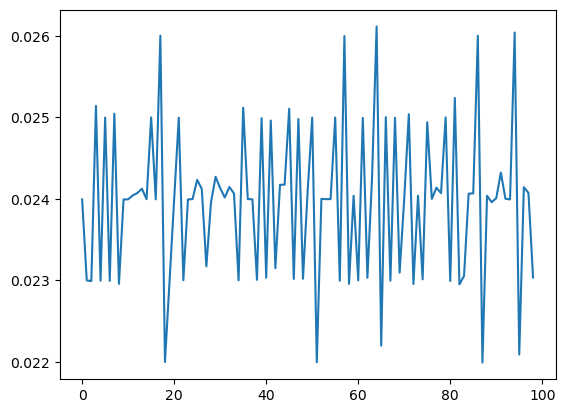

In [13]:
plt.plot([timestamps[i]-timestamps[i-1]-cam.exposure_time for i in range(timestamps.shape[0]-1)][1:])

In [ ]:
plt.imshow()

In [39]:
import numpy as np
import cv2
import time

# Example stack
stack = im_stack  # shape: (T, H, W)
num_frames = stack.shape[0]

def play_cv_video(stack, delay=50):
    i = 0
    paused = False
    while True:
        frame = stack[i % num_frames]
        cv2.imshow("Video", frame)
        key = cv2.waitKey(delay)

        if key == ord('q'):
            break
        elif key == ord(' '):
            paused = not paused
        elif key == ord('d'):
            i += 1
        elif key == ord('a'):
            i -= 1

        if not paused:
            i += 1

    cv2.destroyAllWindows()

# Run
play_cv_video(stack)


(0, 1744040532.9680476)
(1, 1744040532.992011)
(2, 1744040533.0170488)
(3, 1744040533.0430107)
(4, 1744040533.0690084)
(5, 1744040533.0930073)
(6, 1744040533.11705)
(7, 1744040533.1430492)
(8, 1744040533.1680484)
(9, 1744040533.193009)
(10, 1744040533.2180474)
(11, 1744040533.2430115)
(12, 1744040533.2680073)
(13, 1744040533.293048)
(14, 1744040533.3180494)
(15, 1744040533.3420103)
(16, 1744040533.3680484)
(17, 1744040533.393052)
(18, 1744040533.4180543)
(19, 1744040533.4430935)
(20, 1744040533.467096)
(21, 1744040533.4940517)
(22, 1744040533.5181675)
(23, 1744040533.5431652)
(24, 1744040533.5671659)
(25, 1744040533.5933442)
(26, 1744040533.6183462)
(27, 1744040533.642351)
(28, 1744040533.6683073)
(29, 1744040533.692373)
(30, 1744040533.718392)
(31, 1744040533.742423)
(32, 1744040533.7674685)
(33, 1744040533.7924898)
(34, 1744040533.8174648)
(35, 1744040533.8434634)
(36, 1744040533.8675833)
(37, 1744040533.892534)
(38, 1744040533.9175785)
(39, 1744040533.9429157)
(40, 1744040533.967893

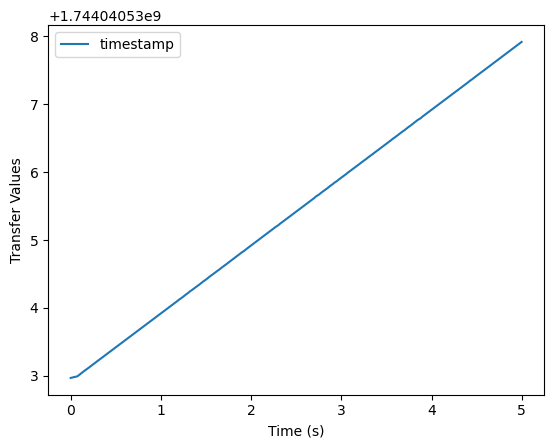

In [11]:
import time
import matplotlib.pyplot as plt
cam._buffer_frames=100
cam.arm()
start_time = time.time()
elapsed_time = 0
results = []

while elapsed_time < 5:
    frame_data, timestamp, frame_count = cam.poll_frame()
    current_time = time.time() - start_time
    results.append((current_time, timestamp, frame_count))
    elapsed_time = current_time



cam.disarm()

times, transfer1, transfer2 = zip(*results)

plt.plot(times, transfer1, label="timestamp")
# plt.plot(times, transfer2, label="Transfer Info 2")
plt.xlabel("Time (s)")
plt.ylabel("Transfer Values")
plt.legend()
plt.show()

In [11]:
del results

In [9]:
cam.hdcam.dcamcap_transferinfo()

(190, 447)

In [5]:
cam.disarm()

In [8]:
cam.set_trigger(False)

In [9]:
num_frames = 100
cam.arm()
last_frame = -1
callback = None
fifo=False
for i_frame in tqdm.tqdm(range(num_frames)):
    try:
        im, timestamp, frame_count = cam.poll_frame(copy=False)
    except RuntimeError as e:
        print(f'Timeout for frame {i_frame} - stopping acquisition. Last frame (camera index): {last_frame}')
        break
    if i_frame == 0:
        first_frame = frame_count
    frame_count -= first_frame
    print(f'frame: {frame_count}')
    if fifo and frame_count - last_frame > 1:
        print(f'{frame_count-last_frame-1} frames dropped. Current frame: {frame_count} (actual); {i_frame} (desired)')
    if callback is not None:
        callback(im, i_frame, timestamp, frame_count)
    last_frame = frame_count
cam.disarm()

  0%|          | 0/100 [00:00<?, ?it/s]


DCAMError: DCAMERR_BUSY

In [4]:
cam.poll_frame()

No frames captured


DCAMError: DCAMERR_NOTREADY

In [11]:
cam.disarm()

In [12]:
cam.close()

In [3]:
cam.roi

{'y_size': 2048,
 'x_size': 2048,
 'y_offset': 0,
 'x_offset': 0,
 'y_bin': 1,
 'x_bin': 1}

In [16]:
cam.sensor_shape

[2048, 2048]

In [13]:
cam.set_roi(y_size=1024,y_offset=24,x_bin=2,y_bin=2)

SyntaxError: invalid syntax (cams.py, line 642)

1

In [4]:
trigger_single.astype(bool)

NameError: name 'trigger_single' is not defined

In [7]:
ramp_samples = int(conf['acquisition']['ramp_seconds'])

ramp = (1 - np.exp(-2 * np.linspace(0, 1, ramp_samples)))*conf['acquisition']['led_percent']*0.01*conf["hardware"]["led_control_v"]


In [9]:
led_single

array([[50., 50., 50., ..., 50., 50., 50.]])

In [40]:
slices = (slice(None), slice(248000, 252000))
slices = list(slices)
ramp_idx = slices[1].start -len(ramp),slices[1].stop-len(ramp)
ramp_idx

array([-2000,  2000])

In [1]:
import yaml
from control import get_full_waveforms
with open(r"/lfm/config/gui_defaults.yml", "r") as file:
        conf = yaml.safe_load(file)
ao_full, do_full, ao_single, do_single, ft = get_full_waveforms(conf)

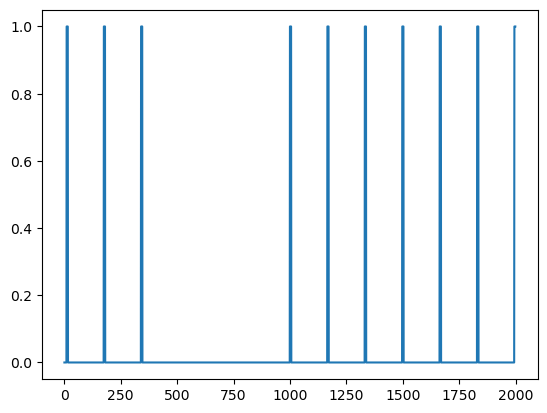

In [12]:
plt.plot(do_full[0,49000:51000])

In [4]:
import numpy as np
import matplotlib.pyplot as plt


In [3]:
1/(1/80)

80.0